
# Detecting LSB stego on color images (Mono version)
### Alberto García - intentodemusico
### Coach - Julián Miranda

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import MirandaAttributes
import shutil, os, random,cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split, KFold

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# **1. Descargar y preparar conjunto de datos**

### Funciones anónimas para obtener las categorías de cada imágen

In [3]:
isStego=lambda x:1 if x[:6]=="stego_" else 0
getYFromImageList=lambda x: [isStego(element) for element in x]

In [17]:
folder="../../../Dataset/Mono/MonoSamples/S-Uniward_5" 

### Orden aleatorio del dataset

In [19]:
images=os.listdir(folder)
random.shuffle(images)
print(len(images))

40000


### Obteniendo las categorías

In [20]:
y=np.array(getYFromImageList(images),dtype='float32')

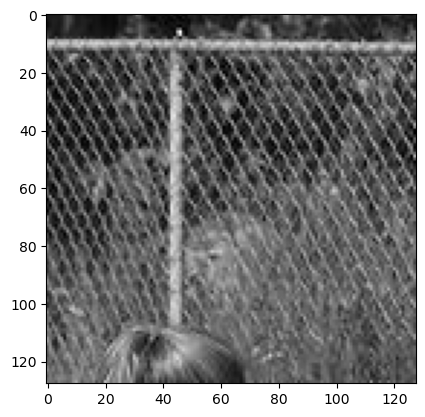

In [22]:
plt.imshow(mpimg.imread(os.path.abspath(os.path.join(folder,images[105]))),cmap="gray")
plt.show()

as [  0   1   2   3 252 253 254 255]


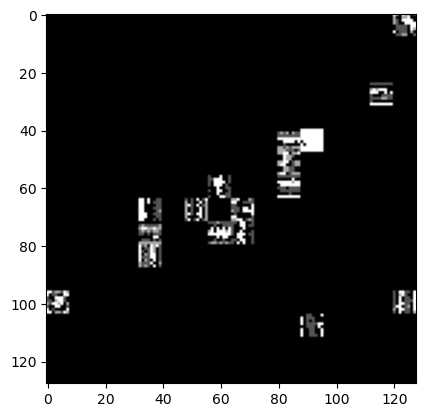

In [23]:
cover=mpimg.imread("cover1.JPEG")#[:,::-1]
stego=mpimg.imread("stego1.JPEG")#[:,::-1]
print("as",np.unique(cover-stego))
plt.imshow((cover-stego)*63,cmap='gray' )#(cover-stego)*255)#-stego)*255)
plt.show()

In [25]:
testShape=mpimg.imread(os.path.abspath(os.path.join(folder,images[1024]))).shape
res=testShape[0] if testShape[1]==testShape[0] else "ERROR, DIFFERENT SIZE ON X AND Y"
channels=1 if len(testShape)<3 else 3
windowSize=16
windowCountPerAxe=res/windowSize

In [26]:
import time

### Obteniendo data de x 
##### (Extensive memory usage)

In [ ]:
t = time.time()
x=np.array([ MirandaAttributes.attributes( mpimg.imread(folder+images[i]) ,windowSize)  for i in range(len(images))],dtype=np.float32)
elapsed = time.time() - t
print(elapsed)

In [ ]:
import gc
gc.enable()
gc.garbage

In [ ]:
x=x.reshape(len(x),512,1)
print(x.shape)

# **3. Base Convolucional**

#### Initializing K-Fold

In [ ]:
kf = KFold(n_splits=5, shuffle=False)
acc_per_fold = []
loss_per_fold = []

In [ ]:
[[y[i],images[i]] for i in range(1,10)]

x=x.reshape(len(x),128,128,1)

In [ ]:
x.shape

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
tf.keras.mixed_precision.experimental.set_policy(policy)

##### (Extensive memory usage)

In [ ]:
#Setting early stopping
earlystopping=callbacks.EarlyStopping(monitor="val_loss", mode="min",patience=20,restore_best_weights=True)
lrScheduler=callbacks.LearningRateScheduler(scheduler)
#Conv
fold_no = 1
for train, test in kf.split(x, y):
    model = models.Sequential()
    model.add(layers.Conv1D(512,1, padding='valid',strides=1, #kernel_initializer=high_pass, #Comment if unwanted kernel
                          input_shape=(512,channels)))
    model.add(layers.MaxPooling1D((2)))
    model.add(layers.Conv1D(1024, 2))
    #model.add(layers.MaxPooling2D((2, 2)))
   # model.add(layers.Conv2D(512, (3, 3), activation='relu'))
   #  model.add(layers.MaxPooling2D((2, 2)))
    #model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
    #Dense
    model.add(layers.Flatten())#, activation='relu'
    model.add(layers.Dense(1024))
    model.add(layers.Dense(512))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128))
    model.add(layers.Dense(2, activation='softmax'))
    #Comp
    #customSGD=tf.optimizers.SGD(learning_rate=0.05) #SGD consume más recursos computacionales, además puede tardar más tiempo optimizando
    customAdam=tf.optimizers.Adam(learning_rate=0.0015)
    model.compile(optimizer=customAdam,
                  loss=tf.keras.losses.binary_crossentropy, #Debería ser binario?
                  metrics=['accuracy',f1_m,precision_m, recall_m])
        # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    #Fitting
    history = model.fit(x[train], y[train],validation_data=(x[test], y[test]), epochs=200, callbacks=[earlystopping,lrScheduler],batch_size=64)
    gc.collect()
    print("\n\n\n\n\nFitted")
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    test_loss, test_acc,f1_score, precision, recall = model.evaluate(x[test], y[test], verbose=2)
    print("Loss:",test_loss, "\nAccuracy:",test_acc,"\nF1 score:",f1_score, "\nPrecision:",precision, "\nRecall",recall)
        
    plt.plot(history.history['precision_m'], label='precision')
    plt.plot(history.history['recall_m'], label = 'recall')
    plt.plot(history.history['f1_m'], label = 'F1')
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.legend(loc='lower right')
    plt.show()
    print("Next fold")
    #dataMqtt={"Fold":str(fold_no),"timestamp":str(datetime.now()),"Loss":str(test_loss), "Acc":str(test_acc),"F1":str(f1_score),"Precision":str( precision),"Recall": str(recal)}
    #dataMqtt_out=json.dumps(data)
    #retMqtt= client1.publish("stegian/data",dataMqtt_out)
    
    # Generate generalization metrics
    scores = model.evaluate(x[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Increase fold number
    fold_no += 1
    gc.collect()

## 

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# **4. Agregar capas densas en la parte superior**

In [ ]:
model.summary()

# **5. Compilar y entrenar el modelo**



In [ ]:
model.save("Mono_Attr_noHPf_WOW5-V3.h5")

# **6. Evaluar el modelo**